## Setup

Load required packages

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import random
import libpysal
import pysal
import pysal.lib
import gpytorch
import torch
import math

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Create functions to save data

In [2]:
def picklecreator_ex1_train(dflist):
    for i, b in enumerate(dflist):
        dflist[b].to_pickle(r'./train_test_data/ex1/ex1_train_fold{:02d}.pkl'.format(i+1))
    return 1
def picklecreator_ex1_test(dflist):
    for i, b in enumerate(dflist):
        dflist[b].to_pickle(r'./train_test_data/ex1/ex1_test_fold{:02d}.pkl'.format(i+1))
    return 1

def picklecreator_ex2_train(dflist):
    for i, b in enumerate(dflist):
        dflist[b].to_pickle(r'./train_test_data/ex2/ex2_train_fold{:02d}.pkl'.format(i+1))
    return 1
def picklecreator_ex2_test(dflist):
    for i, b in enumerate(dflist):
        dflist[b].to_pickle(r'./train_test_data/ex2/ex2_test_fold{:02d}.pkl'.format(i+1))
    return 1

## Spatial Grid Expansion using `GPyTorch`

Define multi-output GP model for interpolating grid values

In [3]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dim=2,has_lengthscale=True), grid_size=grid_size, num_dims=2,
            ), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

Define grid expansion function. This function takes in a regular point grid dataset `data` with coordinates `longitude` and `latitude` and features `y` and `z` and a factor `fact` by which to expand the grid.

The `MultitaskGPModel` defined above is then used to interpolate values `y` and `z` at the new, synthetic points in order to artificially inflate the training set.

In [4]:
def grid_expand_GP(data,fact):
    
    #Create lon and lat groups (for the case that the test data splits our regular box in two (geographically) separate training sets)
    lon_unique = data.longitude.unique() #Get unique lon/lat values
    inp = np.insert(np.diff(data.longitude.unique()),0,np.min(np.diff(data.longitude.unique()))) #Get differences at each step
    res = []
    k = 1
    for i in inp: #Loop over differences and assign new group if a gap is detected
        if i != np.min(inp):
            k = k+1
        else:
            k = k
        res += [k]

    d = {'longitude': lon_unique, 'group_lon': res} #Bind into a dataframe
    lon_group = pd.DataFrame(data=d)
    #Repeat for latitude
    lat_unique = data.latitude.unique()
    inp = np.insert(np.diff(data.latitude.unique()),0,np.min(np.diff(data.latitude.unique())))
    res = []
    k = 1
    for i in inp:
        if i != np.min(inp):
            k = k+1
        else:
            k = k
        res += [k]
    d = {'latitude': lat_unique, 'group_lat': res}
    lat_group = pd.DataFrame(data=d)
    #Merge with input data
    data = pd.merge(lon_group,data, how="right", on=["longitude"])
    data = pd.merge(lat_group,data, how="right", on=["latitude"])
    #Create dataset for storing the final results
    final_data = pd.DataFrame()
    
    for o in data.group_lat.unique():
        #Select group
        temp1_data = data[data["group_lat"]==o]
        for p in temp1_data.group_lon.unique():
            #Select group
            temp_data = temp1_data[temp1_data["group_lon"]==p]
            #Create new grid:
            #Copy column names from existing grid
            new_points = pd.DataFrame(columns=temp_data[["longitude","latitude"]].columns)
            #Expand longitude by factor `fact`
            dst = (temp_data[["longitude"]].max() - temp_data[["longitude"]].min()) / (len(temp_data.longitude.unique())-1)
            exp = float(dst/fact)
            x = []
            d = float(temp_data[["longitude"]].min())
            while d <= float(temp_data[["longitude"]].max()):
                x.append(d)    
                d = d + exp
            #Expand latitude by factor `fact`
            dst = (temp_data[["latitude"]].max() - temp_data[["latitude"]].min()) / (len(temp_data.latitude.unique())-1)
            exp = float(dst/fact)
            y = []
            d = float(temp_data[["latitude"]].min())
            while d <= float(temp_data[["latitude"]].max()):
                y.append(d)    
                d = d + exp
            #Bind new lat and lon values
            lon = x * len(y)
            lat = sorted(y*len(x))
            #Create new points dataframe
            new_points = pd.DataFrame({"longitude":lon,"latitude":lat})
            #Merge with existing dataframe
            new_data = pd.merge(new_points,data, how="left", on=["longitude","latitude"])
            #Create column to indicate whether observation is original or synthetic 
            new_data["synth"] = 0
            new_data.loc[new_data.id.isnull(), "synth"] = 1

            #Spatial operations:
            #Compute distance matrix of new grid
            dist = pysal.lib.cg.distance_matrix(np.array(new_data[["longitude","latitude"]]))
            #Extract and flatten 10 nearest distances
            k=10
            u_dist = np.unique(dist)
            k_min_dist = np.sort(u_dist.flatten())[:k]
            #Create KD tree
            kd = pysal.lib.cg.kdtree.KDTree(np.array(new_data[["longitude","latitude"]]))
            #Define neighbourhood (here Queen structure)
            w = pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[2],binary=True,p=2) #Queen
            #Bind to existing data
            final_data = pd.concat([final_data, new_data])
        
    ###
    # GP INTERPOLATION (CAN BE COMMENTED OUT TO GET NA GRID)
    #Get train and test data
    train = final_data[final_data["synth"]==0]
    test = final_data[final_data["synth"]==1]
    #Covert to pytorch tensor
    train_x = torch.from_numpy(np.asarray(train[["longitude","latitude"]])).float().cuda()
    train_y = torch.from_numpy(np.asarray(train[["y","z"]])).float().cuda()
    test_x = torch.from_numpy(np.asarray(test[["longitude","latitude"]])).float().cuda()
    #Train GP
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2).cuda()
    model = MultitaskGPModel(train_x, train_y, likelihood).cuda()
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    n_iter = 150
    for i in range(n_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
        optimizer.step()
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    model = MultitaskGPModel(train_x, train_y, likelihood).cuda()
    # Set into eval mode
    model.eval()
    likelihood.eval()
    # Make predictions
    with torch.no_grad(), gpytorch.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        # Get mean
        mean = observed_pred.mean
        # Get lower and upper confidence bounds
        lower, upper = observed_pred.confidence_region()
    #Convert results back to GP
    test[["longitude","latitude"]] = test_x.cpu().numpy()
    test[["y","z"]] = mean.cpu().numpy()     
    #Create final dataframe
    final_data = pd.concat([train, test])
    ### 
    
    #Re-assign IDs
    final_data[["id"]] = np.asarray(list(range(0,len(final_data["id"])))).reshape(-1,1)
    #Delete helper columns
    final_data = final_data.drop(columns=["group_lat","group_lon"])
    #Return new dataframe
    return final_data

### Grid Expansion: Synthetic data example 1

We first create lists of training and testing data for each of the 10 cross-validation folds (defined by lat / lon slicing)

In [5]:
#Read data
data = pd.read_csv("grid_aug_ex1.csv")
#Create train/test lists by fold
d_train = {}
d_test = {}
for name in data.filter(regex="fold").columns:
    d_train[name] = data[data[name]==2]
    d_train[name] = d_train[name][d_train[name].columns.drop(list(d_train[name].filter(regex='fold')))] 
    d_test[name] = data[data[name]==1]
    d_test[name] = d_test[name][d_test[name].columns.drop(list(d_test[name].filter(regex='fold')))] 

Create the new, synthetic training data using `grid_expand_GP`

In [6]:
for name, df in d_train.items():
    d_train[name] = grid_expand_GP(d_train[name],2)

Iter 1/150 - Loss: 391.456
Iter 2/150 - Loss: 385.909
Iter 3/150 - Loss: 379.325
Iter 4/150 - Loss: 375.756
Iter 5/150 - Loss: 370.161
Iter 6/150 - Loss: 365.833
Iter 7/150 - Loss: 363.116
Iter 8/150 - Loss: 359.724
Iter 9/150 - Loss: 354.838
Iter 10/150 - Loss: 351.912
Iter 11/150 - Loss: 348.122
Iter 12/150 - Loss: 344.804
Iter 13/150 - Loss: 343.192
Iter 14/150 - Loss: 339.673
Iter 15/150 - Loss: 337.817
Iter 16/150 - Loss: 334.869
Iter 17/150 - Loss: 329.755
Iter 18/150 - Loss: 327.893
Iter 19/150 - Loss: 322.422
Iter 20/150 - Loss: 318.311
Iter 21/150 - Loss: 316.720
Iter 22/150 - Loss: 310.801
Iter 23/150 - Loss: 307.162
Iter 24/150 - Loss: 303.508
Iter 25/150 - Loss: 304.348
Iter 26/150 - Loss: 298.723
Iter 27/150 - Loss: 289.304
Iter 28/150 - Loss: 291.777
Iter 29/150 - Loss: 287.180
Iter 30/150 - Loss: 288.133
Iter 31/150 - Loss: 279.544
Iter 32/150 - Loss: 276.055
Iter 33/150 - Loss: 278.816
Iter 34/150 - Loss: 269.678
Iter 35/150 - Loss: 273.273
Iter 36/150 - Loss: 265.076
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Iter 1/150 - Loss: 342.839
Iter 2/150 - Loss: 337.773
Iter 3/150 - Loss: 330.454
Iter 4/150 - Loss: 323.657
Iter 5/150 - Loss: 318.578
Iter 6/150 - Loss: 315.533
Iter 7/150 - Loss: 311.780
Iter 8/150 - Loss: 306.801
Iter 9/150 - Loss: 302.543
Iter 10/150 - Loss: 301.620
Iter 11/150 - Loss: 300.301
Iter 12/150 - Loss: 294.874
Iter 13/150 - Loss: 290.527
Iter 14/150 - Loss: 289.431
Iter 15/150 - Loss: 285.571
Iter 16/150 - Loss: 281.808
Iter 17/150 - Loss: 278.362
Iter 18/150 - Loss: 276.346
Iter 19/150 - Loss: 266.066
Iter 20/150 - Loss: 264.438
Iter 21/150 - Loss: 259.597
Iter 22/150 - Loss: 260.890
Iter 23/150 - Loss: 258.366
Iter 24/150 - Loss: 250.052
Iter 25/150 - Loss: 248.952
Iter 26/150 - Loss: 245.292
Iter 27/150 - Loss: 241.709
Iter 28/150 - Loss: 234.833
Iter 29/150 - Loss: 232.710
Iter 30/150 - Loss: 226.765
Iter 31/150 - Loss: 226.200
Iter 32/150 - Loss: 221.324
Iter 33/150 - Loss: 220.558
Iter 34/150 - Loss: 213.681
Iter 35/150 - Loss: 209.041
Iter 36/150 - Loss: 206.760
I

Iter 146/150 - Loss: 26.677
Iter 147/150 - Loss: 27.095
Iter 148/150 - Loss: 19.379
Iter 149/150 - Loss: 14.253
Iter 150/150 - Loss: 24.284
Iter 1/150 - Loss: 340.905
Iter 2/150 - Loss: 331.679
Iter 3/150 - Loss: 327.886
Iter 4/150 - Loss: 320.646
Iter 5/150 - Loss: 317.763
Iter 6/150 - Loss: 314.625
Iter 7/150 - Loss: 311.051
Iter 8/150 - Loss: 307.796
Iter 9/150 - Loss: 304.440
Iter 10/150 - Loss: 301.749
Iter 11/150 - Loss: 299.345
Iter 12/150 - Loss: 296.788
Iter 13/150 - Loss: 293.026
Iter 14/150 - Loss: 290.497
Iter 15/150 - Loss: 286.809
Iter 16/150 - Loss: 284.864
Iter 17/150 - Loss: 280.850
Iter 18/150 - Loss: 277.574
Iter 19/150 - Loss: 269.679
Iter 20/150 - Loss: 265.923
Iter 21/150 - Loss: 263.365
Iter 22/150 - Loss: 259.958
Iter 23/150 - Loss: 254.527
Iter 24/150 - Loss: 250.562
Iter 25/150 - Loss: 249.203
Iter 26/150 - Loss: 245.349
Iter 27/150 - Loss: 246.641
Iter 28/150 - Loss: 240.760
Iter 29/150 - Loss: 236.723
Iter 30/150 - Loss: 233.480
Iter 31/150 - Loss: 230.324
I

Iter 141/150 - Loss: 43.145
Iter 142/150 - Loss: 41.981
Iter 143/150 - Loss: 44.142
Iter 144/150 - Loss: 45.395
Iter 145/150 - Loss: 47.480
Iter 146/150 - Loss: 73.340
Iter 147/150 - Loss: 40.499
Iter 148/150 - Loss: 56.972
Iter 149/150 - Loss: 42.895
Iter 150/150 - Loss: 31.712
Iter 1/150 - Loss: 403.101
Iter 2/150 - Loss: 397.303
Iter 3/150 - Loss: 391.375
Iter 4/150 - Loss: 385.186
Iter 5/150 - Loss: 380.219
Iter 6/150 - Loss: 372.761
Iter 7/150 - Loss: 369.338
Iter 8/150 - Loss: 363.028
Iter 9/150 - Loss: 359.964
Iter 10/150 - Loss: 351.982
Iter 11/150 - Loss: 352.974
Iter 12/150 - Loss: 346.962
Iter 13/150 - Loss: 344.971
Iter 14/150 - Loss: 340.399
Iter 15/150 - Loss: 337.419
Iter 16/150 - Loss: 331.707
Iter 17/150 - Loss: 328.169
Iter 18/150 - Loss: 328.088
Iter 19/150 - Loss: 317.198
Iter 20/150 - Loss: 316.175
Iter 21/150 - Loss: 313.113
Iter 22/150 - Loss: 310.899
Iter 23/150 - Loss: 303.382
Iter 24/150 - Loss: 304.315
Iter 25/150 - Loss: 295.840
Iter 26/150 - Loss: 292.938
I

Iter 136/150 - Loss: -3.975
Iter 137/150 - Loss: 11.493
Iter 138/150 - Loss: 36.056
Iter 139/150 - Loss: 13.152
Iter 140/150 - Loss: 23.717
Iter 141/150 - Loss: 23.613
Iter 142/150 - Loss: 25.855
Iter 143/150 - Loss: 18.549
Iter 144/150 - Loss: 12.603
Iter 145/150 - Loss: 12.732
Iter 146/150 - Loss: 15.584
Iter 147/150 - Loss: 14.038
Iter 148/150 - Loss: 10.705
Iter 149/150 - Loss: -4.487
Iter 150/150 - Loss: 10.064
Iter 1/150 - Loss: 355.217
Iter 2/150 - Loss: 348.098
Iter 3/150 - Loss: 343.574
Iter 4/150 - Loss: 337.627
Iter 5/150 - Loss: 331.753
Iter 6/150 - Loss: 326.826
Iter 7/150 - Loss: 320.243
Iter 8/150 - Loss: 317.317
Iter 9/150 - Loss: 312.692
Iter 10/150 - Loss: 307.296
Iter 11/150 - Loss: 307.538
Iter 12/150 - Loss: 303.857
Iter 13/150 - Loss: 298.665
Iter 14/150 - Loss: 293.841
Iter 15/150 - Loss: 292.222
Iter 16/150 - Loss: 289.655
Iter 17/150 - Loss: 285.488
Iter 18/150 - Loss: 280.251
Iter 19/150 - Loss: 277.901
Iter 20/150 - Loss: 272.190
Iter 21/150 - Loss: 270.805
I

Iter 131/150 - Loss: 8.267
Iter 132/150 - Loss: 9.655
Iter 133/150 - Loss: 21.595
Iter 134/150 - Loss: 24.219
Iter 135/150 - Loss: -5.305
Iter 136/150 - Loss: 15.006
Iter 137/150 - Loss: 21.193
Iter 138/150 - Loss: 4.841
Iter 139/150 - Loss: 8.240
Iter 140/150 - Loss: 12.197
Iter 141/150 - Loss: 15.423
Iter 142/150 - Loss: 28.601
Iter 143/150 - Loss: 47.641
Iter 144/150 - Loss: 11.667
Iter 145/150 - Loss: 17.872
Iter 146/150 - Loss: 36.416
Iter 147/150 - Loss: 10.993
Iter 148/150 - Loss: 17.318
Iter 149/150 - Loss: 13.876
Iter 150/150 - Loss: 16.602
Iter 1/150 - Loss: 396.443
Iter 2/150 - Loss: 391.207
Iter 3/150 - Loss: 384.839
Iter 4/150 - Loss: 379.078
Iter 5/150 - Loss: 376.563
Iter 6/150 - Loss: 370.218
Iter 7/150 - Loss: 367.340
Iter 8/150 - Loss: 361.281
Iter 9/150 - Loss: 359.681
Iter 10/150 - Loss: 353.823
Iter 11/150 - Loss: 352.168
Iter 12/150 - Loss: 350.491
Iter 13/150 - Loss: 346.295
Iter 14/150 - Loss: 341.405
Iter 15/150 - Loss: 339.792
Iter 16/150 - Loss: 335.065
Iter 

Save train / test data for each fold as pickle file

In [8]:
picklecreator_ex1_train(d_train)
picklecreator_ex1_test(d_test)

1

### Grid Expansion: Synthetic data example 2

In [9]:
#Read data
data = pd.read_csv("grid_aug_ex2.csv")
#Create train/test lists by fold
d_train = {}
d_test = {}
for name in data.filter(regex="fold").columns:
    d_train[name] = data[data[name]==2]
    d_train[name] = d_train[name][d_train[name].columns.drop(list(d_train[name].filter(regex='fold')))] 
    d_test[name] = data[data[name]==1]
    d_test[name] = d_test[name][d_test[name].columns.drop(list(d_test[name].filter(regex='fold')))] 

In [10]:
for name, df in d_train.items():
    d_train[name] = grid_expand_GP(d_train[name],2)

Iter 1/150 - Loss: 966.812
Iter 2/150 - Loss: 957.510
Iter 3/150 - Loss: 945.453
Iter 4/150 - Loss: 934.345
Iter 5/150 - Loss: 924.076
Iter 6/150 - Loss: 916.228
Iter 7/150 - Loss: 905.691
Iter 8/150 - Loss: 899.071
Iter 9/150 - Loss: 893.567
Iter 10/150 - Loss: 891.214
Iter 11/150 - Loss: 888.700
Iter 12/150 - Loss: 888.591
Iter 13/150 - Loss: 886.962
Iter 14/150 - Loss: 886.750
Iter 15/150 - Loss: 886.259
Iter 16/150 - Loss: 884.998
Iter 17/150 - Loss: 883.721
Iter 18/150 - Loss: 882.233
Iter 19/150 - Loss: 880.725
Iter 20/150 - Loss: 878.513
Iter 21/150 - Loss: 877.094
Iter 22/150 - Loss: 875.623
Iter 23/150 - Loss: 874.534
Iter 24/150 - Loss: 872.033
Iter 25/150 - Loss: 871.690
Iter 26/150 - Loss: 870.753
Iter 27/150 - Loss: 869.380
Iter 28/150 - Loss: 870.133
Iter 29/150 - Loss: 869.021
Iter 30/150 - Loss: 869.754
Iter 31/150 - Loss: 869.330
Iter 32/150 - Loss: 868.724
Iter 33/150 - Loss: 868.419
Iter 34/150 - Loss: 868.238
Iter 35/150 - Loss: 867.445
Iter 36/150 - Loss: 867.356
I

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Iter 1/150 - Loss: 896.699
Iter 2/150 - Loss: 890.475
Iter 3/150 - Loss: 878.413
Iter 4/150 - Loss: 870.063
Iter 5/150 - Loss: 863.434
Iter 6/150 - Loss: 858.097
Iter 7/150 - Loss: 852.083
Iter 8/150 - Loss: 847.098
Iter 9/150 - Loss: 845.100
Iter 10/150 - Loss: 836.971
Iter 11/150 - Loss: 834.657
Iter 12/150 - Loss: 829.698
Iter 13/150 - Loss: 821.551
Iter 14/150 - Loss: 820.322
Iter 15/150 - Loss: 814.965
Iter 16/150 - Loss: 810.773
Iter 17/150 - Loss: 807.971
Iter 18/150 - Loss: 805.977
Iter 19/150 - Loss: 804.574
Iter 20/150 - Loss: 803.042
Iter 21/150 - Loss: 802.709
Iter 22/150 - Loss: 801.625
Iter 23/150 - Loss: 800.795
Iter 24/150 - Loss: 800.960
Iter 25/150 - Loss: 800.338
Iter 26/150 - Loss: 799.195
Iter 27/150 - Loss: 795.868
Iter 28/150 - Loss: 795.402
Iter 29/150 - Loss: 792.522
Iter 30/150 - Loss: 791.214
Iter 31/150 - Loss: 789.652
Iter 32/150 - Loss: 788.174
Iter 33/150 - Loss: 787.809
Iter 34/150 - Loss: 786.757
Iter 35/150 - Loss: 786.952
Iter 36/150 - Loss: 786.923
I

Iter 140/150 - Loss: 833.274
Iter 141/150 - Loss: 833.487
Iter 142/150 - Loss: 833.618
Iter 143/150 - Loss: 833.692
Iter 144/150 - Loss: 833.533
Iter 145/150 - Loss: 833.506
Iter 146/150 - Loss: 833.512
Iter 147/150 - Loss: 833.586
Iter 148/150 - Loss: 833.401
Iter 149/150 - Loss: 833.358
Iter 150/150 - Loss: 833.333
Iter 1/150 - Loss: 877.543
Iter 2/150 - Loss: 869.480
Iter 3/150 - Loss: 860.721
Iter 4/150 - Loss: 855.256
Iter 5/150 - Loss: 854.092
Iter 6/150 - Loss: 851.705
Iter 7/150 - Loss: 849.562
Iter 8/150 - Loss: 848.729
Iter 9/150 - Loss: 844.638
Iter 10/150 - Loss: 842.470
Iter 11/150 - Loss: 838.824
Iter 12/150 - Loss: 837.179
Iter 13/150 - Loss: 834.781
Iter 14/150 - Loss: 833.518
Iter 15/150 - Loss: 831.389
Iter 16/150 - Loss: 829.443
Iter 17/150 - Loss: 827.255
Iter 18/150 - Loss: 824.122
Iter 19/150 - Loss: 822.574
Iter 20/150 - Loss: 821.965
Iter 21/150 - Loss: 819.878
Iter 22/150 - Loss: 819.148
Iter 23/150 - Loss: 817.021
Iter 24/150 - Loss: 815.770
Iter 25/150 - Loss

Iter 129/150 - Loss: 873.322
Iter 130/150 - Loss: 873.226
Iter 131/150 - Loss: 873.232
Iter 132/150 - Loss: 873.265
Iter 133/150 - Loss: 873.216
Iter 134/150 - Loss: 873.203
Iter 135/150 - Loss: 873.232
Iter 136/150 - Loss: 873.140
Iter 137/150 - Loss: 873.238
Iter 138/150 - Loss: 873.153
Iter 139/150 - Loss: 873.142
Iter 140/150 - Loss: 873.205
Iter 141/150 - Loss: 873.268
Iter 142/150 - Loss: 873.085
Iter 143/150 - Loss: 873.178
Iter 144/150 - Loss: 873.114
Iter 145/150 - Loss: 873.095
Iter 146/150 - Loss: 873.189
Iter 147/150 - Loss: 873.224
Iter 148/150 - Loss: 873.118
Iter 149/150 - Loss: 873.079
Iter 150/150 - Loss: 873.122
Iter 1/150 - Loss: 1033.278
Iter 2/150 - Loss: 1023.539
Iter 3/150 - Loss: 1014.077
Iter 4/150 - Loss: 1003.224
Iter 5/150 - Loss: 991.739
Iter 6/150 - Loss: 982.503
Iter 7/150 - Loss: 972.505
Iter 8/150 - Loss: 967.904
Iter 9/150 - Loss: 963.216
Iter 10/150 - Loss: 956.383
Iter 11/150 - Loss: 951.802
Iter 12/150 - Loss: 945.457
Iter 13/150 - Loss: 946.325
Ite

Iter 118/150 - Loss: 837.885
Iter 119/150 - Loss: 837.830
Iter 120/150 - Loss: 837.747
Iter 121/150 - Loss: 837.980
Iter 122/150 - Loss: 837.854
Iter 123/150 - Loss: 837.730
Iter 124/150 - Loss: 837.687
Iter 125/150 - Loss: 837.858
Iter 126/150 - Loss: 837.904
Iter 127/150 - Loss: 837.823
Iter 128/150 - Loss: 837.823
Iter 129/150 - Loss: 837.888
Iter 130/150 - Loss: 837.760
Iter 131/150 - Loss: 837.711
Iter 132/150 - Loss: 837.802
Iter 133/150 - Loss: 837.849
Iter 134/150 - Loss: 837.687
Iter 135/150 - Loss: 837.592
Iter 136/150 - Loss: 837.697
Iter 137/150 - Loss: 837.714
Iter 138/150 - Loss: 837.653
Iter 139/150 - Loss: 837.570
Iter 140/150 - Loss: 837.715
Iter 141/150 - Loss: 837.797
Iter 142/150 - Loss: 837.742
Iter 143/150 - Loss: 837.734
Iter 144/150 - Loss: 837.568
Iter 145/150 - Loss: 837.675
Iter 146/150 - Loss: 837.676
Iter 147/150 - Loss: 837.686
Iter 148/150 - Loss: 837.535
Iter 149/150 - Loss: 837.673
Iter 150/150 - Loss: 837.820
Iter 1/150 - Loss: 918.278
Iter 2/150 - Los

Iter 107/150 - Loss: 746.832
Iter 108/150 - Loss: 746.744
Iter 109/150 - Loss: 746.878
Iter 110/150 - Loss: 746.993
Iter 111/150 - Loss: 746.836
Iter 112/150 - Loss: 746.718
Iter 113/150 - Loss: 746.804
Iter 114/150 - Loss: 746.829
Iter 115/150 - Loss: 746.543
Iter 116/150 - Loss: 746.672
Iter 117/150 - Loss: 746.637
Iter 118/150 - Loss: 746.675
Iter 119/150 - Loss: 746.663
Iter 120/150 - Loss: 746.498
Iter 121/150 - Loss: 746.809
Iter 122/150 - Loss: 746.681
Iter 123/150 - Loss: 746.647
Iter 124/150 - Loss: 746.621
Iter 125/150 - Loss: 746.535
Iter 126/150 - Loss: 746.609
Iter 127/150 - Loss: 746.536
Iter 128/150 - Loss: 746.555
Iter 129/150 - Loss: 746.506
Iter 130/150 - Loss: 746.581
Iter 131/150 - Loss: 746.337
Iter 132/150 - Loss: 746.552
Iter 133/150 - Loss: 746.490
Iter 134/150 - Loss: 746.422
Iter 135/150 - Loss: 746.537
Iter 136/150 - Loss: 746.539
Iter 137/150 - Loss: 746.519
Iter 138/150 - Loss: 746.407
Iter 139/150 - Loss: 746.467
Iter 140/150 - Loss: 746.410
Iter 141/150 -

In [11]:
picklecreator_ex2_train(d_train)
picklecreator_ex2_test(d_test)

1

### Plot some exampled for the expanded grid

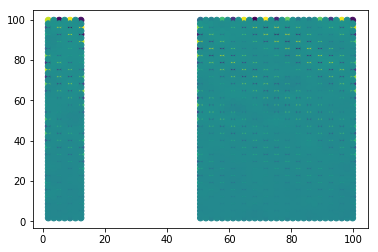

In [12]:
import matplotlib.pyplot as plt
plt.scatter(d_train["fold2"]["longitude"],d_train["fold2"]["latitude"],c=d_train["fold2"]["y"])

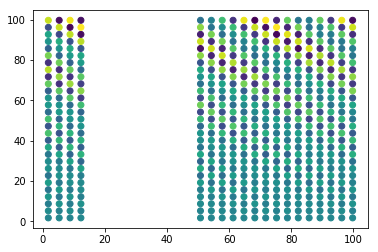

In [15]:
plt.scatter(data[data["fold2"]==2]["longitude"],data[data["fold2"]==2]["latitude"],c=data[data["fold2"]==2]["y"])